# Summary

In this notebook we train a NN with multiple real sequences per batch.

---

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [2]:
%run _imports.ipynb

Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-01-02 12:08:58.352174


In [3]:
%run _settings.ipynb

In [4]:
from typing import NamedTuple
import random
random.seed(42)

import h5py
from sklearn import metrics

In [5]:
import pagnn
importlib.reload(pagnn)

<module 'pagnn' from '/home/kimlab1/strokach/working/pagnn/pagnn/__init__.py'>

In [6]:
NOTEBOOK_NAME = 'train_neural_network'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

# Parameters

In [7]:
ADJACENCY_MATRIX_PATH = (
    Path('/home/strokach/databin')
    .joinpath('uniparc_domain')
    .joinpath('0.1')
    .joinpath('adjacency_matrix.parquet')
    .absolute()
)
ADJACENCY_MATRIX_PATH

PosixPath('/home/strokach/databin/uniparc_domain/0.1/adjacency_matrix.parquet')

In [8]:
!ls /home/strokach/databin/uniparc_domain/0.1/adjacency_matrix.parquet

adjacency_matrix.parquet	   database_id=G3DSA%3A2.70.240.10
database_id=G3DSA%3A1.10.1000.11   database_id=G3DSA%3A2.70.250.10
database_id=G3DSA%3A1.10.100.10    database_id=G3DSA%3A2.70.40.20
database_id=G3DSA%3A1.10.10.10	   database_id=G3DSA%3A2.70.50.30
database_id=G3DSA%3A1.10.101.10    database_id=G3DSA%3A2.70.50.40
database_id=G3DSA%3A1.10.10.140    database_id=G3DSA%3A2.70.9.10
database_id=G3DSA%3A1.10.10.180    database_id=G3DSA%3A2.70.9.30
database_id=G3DSA%3A1.10.10.190    database_id=G3DSA%3A2.70.98.10
database_id=G3DSA%3A1.10.10.200    database_id=G3DSA%3A2.70.98.20
database_id=G3DSA%3A1.10.1020.10   database_id=G3DSA%3A2.70.98.40
database_id=G3DSA%3A1.10.10.250    database_id=G3DSA%3A2.90.10.10
database_id=G3DSA%3A1.10.1030.10   database_id=G3DSA%3A3.10.100.10
database_id=G3DSA%3A1.10.10.350    database_id=G3DSA%3A3.10.110.10
database_id=G3DSA%3A1.10.10.390    database_id=G3DSA%3A3.10.120.10
database_id=G3DSA%3A1.10.10.400    database_id=G3DSA%3A3.10.130.10
database_id=G3

## Gene3D domains

In [9]:
with open(f'generate_datasets/gene3d_domains.pickle', 'rb') as fin:
    GENE3D_DOMAINS = pickle.load(fin)

## Training / validation domains

In [10]:
with open(f'generate_datasets/training_domains.pickle', 'rb') as fin:
    TRAINING_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/validation_domains.pickle', 'rb') as fin:
    VALIDATION_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/test_domains.pickle', 'rb') as fin:
    TEST_DOMAINS = pickle.load(fin)

## Training / validation parquet files

In [11]:
with open(f'generate_datasets/training_parquet_files.pickle', 'rb') as fin:
    TRAINING_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/validation_parquet_files.pickle', 'rb') as fin:
    VALIDATION_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/test_parquet_files.pickle', 'rb') as fin:
    TEST_PARQUET_FILES = pickle.load(fin)

## Folders

In [12]:
VALIDATION_DIR = NOTEBOOK_PATH.joinpath('validation')

# New heading

# Datasets

This section can be skipped if it was done already!

## Validation dataset

In [15]:
if list(VALIDATION_DIR.glob('**/*.parquet')):
    raise Exception("Validation dataset already exists!")

Exception: Validation dataset already exists!

In [23]:
VALIDATION_DOMAINS[:2]

['database_id=G3DSA%3A1.10.170.10', 'database_id=G3DSA%3A2.40.380.10']

In [24]:
validation_domain_folders = [
    ADJACENCY_MATRIX_PATH.joinpath(domain)
    for domain in VALIDATION_DOMAINS
]

In [25]:
validation_domain_weights = [
    pagnn.count_domain_rows(domain_folder)
    for domain_folder in validation_domain_folders
]

In [26]:
random.seed(42)
np.random.seed(42)

validation_df = pd.DataFrame(
    data=list(itertools.islice(
        pagnn.iter_dataset_rows(validation_domain_folders, validation_domain_weights),
        100_000)))

In [27]:
validation_df.head(2)

,Index,qseq,residue_idx_1_corrected,residue_idx_2_corrected
0,78,GEDAEISPGNAIPLAKIPLGTMIHNVELRKGKGAQIARGAGTFAQLMAKEGEYGHVRLPSGEVRLVRLECFATIGQV,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 3.0, 10.0, 11.0, 12.0, 70.0, 0.0, 2.0, 3.0, 11.0, 12.0, 15.0, 70.0, 0.0, 1.0, 3.0, 4.0, 0.0, 1.0, 2.0, 4...."
1,1334,KMAFTLADRVTEEMLADKAALVVEVVEENYHDAPIVGIAVVNEHGRFFLRPETALADPQFVAWLGDETKKKSMFDSKRAAVALKWKGIELCGVSFDLLLAAYLLDPAQGVDDVAAA...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 147.0, 151.0, 0.0, 2.0, 3.0, 45.0, 121.0, 123.0, 147.0, 150.0, 151.0, 154.0, 0.0, 1.0, 3.0, 4.0, 45.0, 15..."


In [29]:
VALIDATION_DIR.mkdir(exist_ok=True)

pq.write_table(
    pa.Table.from_pandas(validation_df),
    VALIDATION_DIR.joinpath('validation.parquet').as_posix(),
#     row_group_size=10_000,
    version='2.0',
    flavor='spark',
)

## Protherm dataset

## Humsavar dataset

# Train

#### `validation_datasets`

In [115]:
VALIDATION_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/train_neural_network/validation')

In [116]:
validation_datasets = list(
    pagnn.iter_datasets(
        pagnn.iter_domain_rows(VALIDATION_DIR), 50_000)
)

In [117]:
len(validation_datasets)

254

In [118]:
validation_datasets_file = NOTEBOOK_PATH.joinpath('validation_datasets.pickle')

with validation_datasets_file.open('wb') as fout:
    pickle.dump(validation_datasets, fout, pickle.HIGHEST_PROTOCOL)

#### Prepare training datasets

In [13]:
TRAINING_DOMAINS[:2]

['database_id=G3DSA%3A2.40.128.20', 'database_id=G3DSA%3A3.50.40.10']

In [14]:
training_domain_folders = [
    ADJACENCY_MATRIX_PATH.joinpath(domain)
    for domain in TRAINING_DOMAINS
]

training_domain_folders_file = NOTEBOOK_PATH.joinpath('training_domain_folders.pickle')
with training_domain_folders_file.open('wb') as fout:
    pickle.dump(training_domain_folders, fout, pickle.HIGHEST_PROTOCOL)

In [15]:
training_domain_weights_file = NOTEBOOK_PATH.joinpath('training_domain_weights.pickle')

if training_domain_weights_file.is_file():
    with training_domain_weights_file.open('rb') as fin:
        training_domain_weights = pickle.load(fin)
else:
    training_domain_weights = [
        pagnn.count_domain_rows(domain_folder)
        for domain_folder in training_domain_folders
    ]
    with training_domain_weights_file.open('wb') as fout:
        pickle.dump(training_domain_weights, fout, pickle.HIGHEST_PROTOCOL)

## Run

In [18]:
importlib.reload(pagnn.models)

<module 'pagnn.models' from '/home/kimlab1/strokach/working/pagnn/pagnn/models/__init__.py'>

### Script

In [ ]:
%%file {NOTEBOOK_NAME}/mynet.py
import json
import logging
import os
import os.path as op
import pickle
import random
import time
from pathlib import Path

import GPUtil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn import metrics
from torch.autograd import Variable

import pagnn

logger = logging.getLogger(__name__)

NOTEBOOK_PATH = Path(op.dirname(op.abspath(__file__)))


def init_gpu():
    deviceIDs = GPUtil.getAvailable(order = 'first', limit = 1, maxLoad = 0.5, maxMemory = 0.5)
    os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in deviceIDs)
    os.environ['CUDA_VISIBLE_DEVICES']


def init_network():
    net = pagnn.models.MultiDomainNet().cuda()

    # criterion = nn.MSELoss()
    # criterion = nn.L1Loss()
    criterion = nn.BCELoss()
    # criterion = nn.BCEWithLogitsLoss()

    # optimizer = optim.SGD(net.parameters(), lr=0.2, momentum=0.1)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.001)

    def step(seq_var, adjs_expanded_var, targets_var, calc_score=False):
        """Perform full pass over network.

        Closure with `net`, `criterion`, and `optimizer` in its scope.
        """
        # In the training loop
        optimizer.zero_grad()  # zero the gradient buffers
        output = net(seq_var, adjs_expanded_var)
        loss = criterion(output, targets_var)
        loss.backward()
        optimizer.step()  # Does the update
        if calc_score:
            score = _get_score(output.cpu().data.numpy(), targets_var.cpu().data.numpy().astype(int))
            return score

    def evaluate(datasets):
        """Evaluate the performance of the network."""
        targets = []
        outputs = []
        for idx2, (seq_valid, adjs_valid) in enumerate(datasets[:1]):
            seq_var, adjs_expanded_var, targets_var = get_pytorch_vars(seq_valid, adjs_valid)
            output = net(seq_var, adjs_expanded_var)
            targets.append(targets_var.cpu().data.numpy().astype(int))
            outputs.append(output.cpu().data.numpy())
        outputs = np.hstack(outputs)
        targets = np.hstack(targets)
        score_valid = _get_score(outputs, targets)
        return score_valid
    
    return step, evaluate


def _get_score(outputs, targets):
    score = metrics.roc_auc_score(targets, outputs)
    return score


# @profile
def get_pytorch_vars(seq, adjs):
    seq_permuted = pagnn.permute_sequence(seq)
    seq_ar = np.array([pagnn.get_seq_array(seq), pagnn.get_seq_array(seq_permuted)])
    seq_var = Variable(torch.Tensor(seq_ar)).cuda()

    adjs_expanded = [pagnn.expand_adjacency(adj) for adj in adjs]
    adjs_expanded_var = [Variable(torch.FloatTensor(adj.astype(np.float32))).cuda() for adj in adjs_expanded]

    targets = [1, 0] * len(adjs)
    targets_var = Variable(torch.Tensor(np.array(targets, dtype=np.float32))).cuda()

    return seq_var, adjs_expanded_var, targets_var


# @profile
def main(
        max_seq_length, training_domain_folders, training_domain_weights, validation_datasets, 
        num_aa_to_process=None):
    step, evaluate = init_network()
    
    if num_aa_to_process is not None:
        num_aa_processed = 0
    
    scores = []
    scores_valid = []
    for idx, (seq, adjs) in enumerate(tqdm.tqdm(pagnn.iter_datasets(
            pagnn.iter_dataset_rows(training_domain_folders, training_domain_weights), max_seq_length))):

        seq_var, adjs_expanded_var, targets_var = get_pytorch_vars(seq, adjs)

        calc_score = idx % 100 == 0
        score = step(seq_var, adjs_expanded_var, targets_var, calc_score)
        if score:
            scores.append((idx, score))

        calc_score_valid = idx % 100 == 0
        if calc_score_valid:
            score_valid = evaluate(validation_datasets)
            scores_valid.append(score_valid)
            logger.info("score: %s   score_valid: %s", score, score_valid)

        if num_aa_to_process is not None:
            num_aa_processed += len(seq)
            if num_aa_processed >= num_aa_to_process:
                break

    return cur_seq_length, scores, scores_valid
   

if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-n', '--num-aa-to-process', type=int, default=None)
    parser.add_argument('-m', '--max-seq-length', type=int, default=50_000)
    args = parser.parse_args()
    
    logging.basicConfig(format='%(message)s', level=logging.INFO)

    random.seed(42)
    np.random.seed(42)

    training_domain_folders_file = NOTEBOOK_PATH.joinpath('training_domain_folders.pickle')
    with training_domain_folders_file.open('rb') as fin:
        training_domain_folders = pickle.load(fin)
    
    training_domain_weights_file = NOTEBOOK_PATH.joinpath('training_domain_weights.pickle')
    with training_domain_weights_file.open('rb') as fin:
        training_domain_weights = pickle.load(fin)

    validation_datasets_file = NOTEBOOK_PATH.joinpath('validation_datasets.pickle')
    with validation_datasets_file.open('rb') as fin:
        validation_datasets = pickle.load(fin)
    
    start_time = time.perf_counter()
    cur_seq_length, scores, scores_valid = main(
        args.max_seq_length, training_domain_folders, training_domain_weights, validation_datasets,
        args.num_aa_to_process)
    time_elapsed = time.perf_counter() - start_time

    print(json.dumps({
        'max_seq_length': args.max_seq_length,
        'cur_seq_length': cur_seq_length,
        'time_elapsed': time_elapsed,
        'aa_per_second': cur_seq_length / time_elapsed,
        'scores': scores,
        'scores_valid': scores_valid}))

Overwriting train_neural_network/mynet.py


In [ ]:
!python {NOTEBOOK_NAME}/mynet.py

0it [00:00, ?it/s]score: 0.502735973006   score_valid: 0.514845496384
100it [01:53,  1.13s/it]score: 0.770537464093   score_valid: 0.729776462853
200it [03:34,  1.07s/it]score: 0.803009945581   score_valid: 0.784457593688
300it [05:10,  1.04s/it]score: 0.821124226739   score_valid: 0.797909270217
400it [06:50,  1.03s/it]score: 0.808879964913   score_valid: 0.823760683761
500it [08:31,  1.02s/it]score: 0.803324696152   score_valid: 0.819618671926
600it [10:14,  1.02s/it]score: 0.855353461372   score_valid: 0.828441814596
700it [11:56,  1.02s/it]score: 0.827231711481   score_valid: 0.82006574622
800it [13:39,  1.02s/it]score: 0.856956276975   score_valid: 0.814122287968
900it [15:17,  1.02s/it]score: 0.828369948051   score_valid: 0.823425378041
1000it [16:55,  1.02s/it]score: 0.833504911006   score_valid: 0.824286653517
1100it [18:32,  1.01s/it]score: 0.828029676432   score_valid: 0.820966469428
1200it [20:14,  1.01s/it]score: 0.854561831488   score_valid: 0.832945430638
1300it [21:51,  

### Optimize `max_seq_length`

Looks like the best value for `max_seq_length` is ~ `50_000`.

In [99]:
max_seq_lengths = [
    1_000, 2_000, 5_000, 10_000, 20_000, 40_000, 50_000, 60_000, 80_000, 100_000, 150_000, 200_000,
]

results = []
for max_seq_length in tqdm.tqdm_notebook(max_seq_lengths, total=len(max_seq_lengths)):
    cp = subprocess.run(
        ['python', f'{NOTEBOOK_NAME}/mynet.py', '-n', f'{max_seq_length}'],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    result = json.loads(cp.stdout)
    results.append(result)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [100]:
results_df = pd.DataFrame(results)
results_df

,aa_per_second,cur_seq_length,max_seq_length,time_elapsed
0,28943.225498,1000151,1000,34.555616
1,27138.696535,1001520,2000,36.903762
2,27619.429186,1003149,5000,36.320410
3,27511.062228,1007159,10000,36.609237
4,29106.181792,1012227,20000,34.777045
5,29561.090258,1015984,40000,34.368962
6,29705.715426,1025498,50000,34.521909
7,29691.854348,1054641,60000,35.519540
8,28615.286223,1016651,80000,35.528249
9,27346.139696,1075092,100000,39.314214


Text(0,0.5,'AA / second')

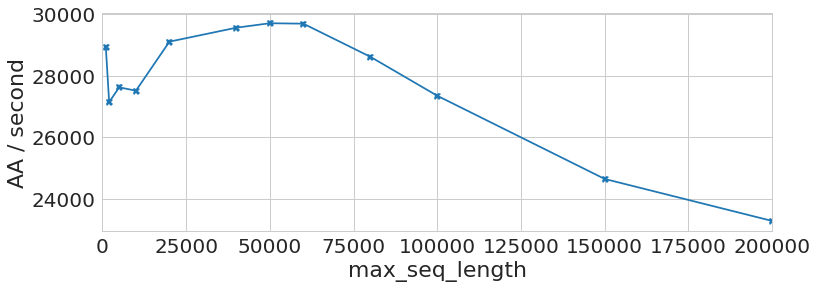

In [112]:
fg, axs = plt.subplots(figsize=(12, 4))
plt.plot(results_df['max_seq_length'], results_df['aa_per_second'], linestyle='-', marker='X')
plt.xlim(0, 200_000)
plt.xlabel('max_seq_length')
plt.ylabel('AA / second')

# sss

In [87]:
!kernprof -l {NOTEBOOK_NAME}/mynet.py -n 10000

Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: Z
Could not convert the following residue to one-hot encoding: Z
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
{"cur_seq_length": 1007159, "time_elapsed": 39.44118913821876, "aa_per_second": 25535.715884997408}
Wrote profile resu

In [53]:
# 10
!python -m line_profiler mynet.py.lprof

Timer unit: 1e-06 s

Total time: 14.4381 s
File: train_neural_network/mynet.py
Function: get_pytorch_vars at line 54

Line #      Hits         Time  Per Hit   % Time  Line Contents
    54                                           @profile
    55                                           def get_pytorch_vars(seq, adjs):
    56       101         4266     42.2      0.0      seq_permuted = pagnn.permute_sequence(seq)
    57       101      1992419  19726.9     13.8      seq_ar = np.array([pagnn.get_seq_array(seq), pagnn.get_seq_array(seq_permuted)])
    58       101      1504810  14899.1     10.4      seq_var = Variable(torch.Tensor(seq_ar)).cuda()
    59                                           
    60       101      7080452  70103.5     49.0      adjs_expanded = [pagnn.expand_adjacency(adj) for adj in adjs]
    61       101      3848183  38100.8     26.7      adjs_expanded_var = [Variable(torch.FloatTensor(adj.astype(np.float32))).cuda() for adj in adjs_expanded]
    62                  

In [24]:
ls

01-generate_datasets.ipynb               _imports.ipynb
02-train_neural_network-gpu-Copy1.ipynb  mynet.py.lprof
02-train_neural_network-gpu.ipynb        _settings.ipynb
02-train_neural_network.ipynb            _spark.ipynb
demo.ipynb                               train_neural_network/
generate_datasets/


In [28]:
%time train()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: Z
Could not convert the following residue to one-hot encoding: Z
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot enco

CPU times: user 2min 7s, sys: 8.56 s, total: 2min 16s
Wall time: 2min 18s


In [30]:
%time train()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: U
Could not convert the following residue to one-hot encoding: Z
Could not convert the following residue to one-hot encoding: Z
Could not convert the following residue to one-hot encoding: B
Could not convert the following residue to one-hot encoding


CPU times: user 2min 20s, sys: 9.1 s, total: 2min 29s
Wall time: 2min 29s


In [35]:
import gc

gc.collect()

0

In [29]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [31]:
# %lprun -f pagnn.iter_dataset_rows train()  # 40

In [32]:
import gc;

gc.collect()

13387

In [33]:
locals()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [45]:
for idx, (aa, adjs) in enumerate(tqdm.tqdm_notebook(pagnn.iter_datasets(
        pagnn.iter_dataset_rows(training_domain_folders, training_domain_weights), 60_000))):
    
    aa_permuted = pagnn.permute_sequence(aa)
    aa_ar = np.array([pagnn.get_seq_array(aa), pagnn.get_seq_array(aa_permuted)])
    aa_var = Variable(torch.Tensor(aa_ar)).cuda()
    
    adjs_expanded = [pagnn.expand_adjacency(adj) for adj in adjs]
    adjs_expanded_var = [Variable(torch.FloatTensor(adj.astype(np.float32))).cuda() for adj in adjs_expanded]
    
    targets = [1, 0] * len(adjs)
    targets_var = Variable(torch.Tensor(np.array(targets, dtype=np.float32))).cuda()
    
    # In the training loop
    optimizer.zero_grad()  # zero the gradient buffers
    output = net(aa_var, adjs_expanded_var)
    loss = criterion(output, targets_var)
    loss.backward()
    optimizer.step()  # Does the update

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 66
Could not convert the following residue to one-hot encoding: 85
Could not convert the following residue to one-hot encoding: 85
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 90
Could not convert the following residue to one-hot encoding: 85
Could not convert the following residue to one-hot encoding: 85


KeyboardInterrupt: 

In [ ]:
# === Run ===
next_domain_performance = []
train_performance = []
validation_performance = []

idx = 0
for domain_idx, domain_folder in enumerate(tqdm.tqdm_notebook(TRAINING_DOMAINS, total=len(TRAINING_DOMAINS))):
    domain = domain_folder.partition('A%3A')[-1]
    domain_path = ADJACENCY_MATRIX_PATH.joinpath(domain_folder)
    for row_idx, row in enumerate(tqdm.tqdm_notebook(
            pagnn.iter_domain_rows(domain_path, columns=columns), 
            leave=False,
            desc=f'Domain {domain_idx}',
            smoothing=0.9)):
        row_key = f'/{domain}/{row_idx:05d}'
        try:
            dataset = pagnn.row_to_dataset(row, num_real=8, num_fake=56)
        except pagnn.SequenceTooShortError:
            print('Skipping short sequence...')
            continue
    
        # Generate tensors
        aa = np.array([pagnn.get_seq_array(seq) for seq in dataset.seqs])
        aa = Variable(torch.Tensor(aa)).cuda()
        adj_expanded = Variable(torch.FloatTensor(pagnn.expand_adjacency(dataset.adj).astype(np.float32))).cuda()
        targets = Variable(torch.Tensor(dataset.targets.astype(np.float32)), requires_grad=False).cuda()

        # In the training loop
        optimizer.zero_grad()  # zero the gradient buffers
        # import pdb; pdb.set_trace()
        output = net(aa, adj_expanded, [range(aa.size()[-1])])
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()  # Does the update

        if idx % 100 == 0:
            score = metrics.roc_auc_score(targets.cpu().data.numpy().astype(int), output.cpu().data.numpy())
            train_performance.append((idx, score))

        if row_idx == 0:
            score = metrics.roc_auc_score(targets.cpu().data.numpy().astype(int), output.cpu().data.numpy())
            next_domain_performance.append((idx, score))
        
        if row_idx == 0:
            all_test_targets = []
            all_test_predictions = []
#             with h5py.File(VALIDATION_HDF5_FILE.as_posix(), 'r') as hdf5_file:
#                 for grp in tqdm.tqdm_notebook(
#                         hdf5_file, total=len(VALIDATION_DOMAINS), leave=False, desc='Validation'):
#                     for subgrp in list(hdf5_file[grp]):
#                         test_seqs = hdf5_file[grp][subgrp]['seqs'][:]
#                         test_adj = hdf5_file[grp][subgrp]['adj'][:]
#                         test_targets = hdf5_file[grp][subgrp]['targets'][:]

            for test_seqs, test_adj, test_targets in tqdm.tqdm_notebook(
                            test_data, total=len(test_data), leave=False, desc='Validation'):
                        test_aa = np.array([pagnn.get_seq_array(seq) for seq in test_seqs])
                        test_aa = Variable(torch.Tensor(test_aa), requires_grad=False).cuda()
                        test_adj_expanded = Variable(
                            torch.FloatTensor(pagnn.expand_adjacency(test_adj).astype(np.float32)),
                            requires_grad=False).cuda()
                        test_targets = Variable(
                            torch.Tensor(test_targets.astype(np.float32)), requires_grad=False).cuda()

                        predictions = net(test_aa, test_adj_expanded, [range(test_aa.size()[-1])])
                        
                        all_test_targets.append(test_targets.cpu().data.numpy())
                        all_test_predictions.append(predictions.cpu().data.numpy())
                        
            all_test_targets = np.hstack(all_test_targets)
            all_test_predictions = np.hstack(all_test_predictions)
            score = metrics.roc_auc_score(all_test_targets, all_test_predictions)
            validation_performance.append((idx, score))
            print(score)
            
        idx += 1
        
        if row_idx == 1999:
            break

In [ ]:
fg, ax = plt.subplots(figsize=(8, 6))

plt.plot(list(zip(*train_performance))[0], list(zip(*train_performance))[1], label='train')
plt.plot(list(zip(*next_domain_performance))[0], list(zip(*next_domain_performance))[1], 'rX', label='next domain')
plt.plot(list(zip(*validation_performance))[0], list(zip(*validation_performance))[1], label='train', linewidth=4)
plt.ylim = (0, 1)
plt.legend()
plt.xlabel('Batch number')
plt.ylabel('ROC AUC score')